## USEFUL PACKAGES

In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import emoji
import re
from itertools import cycle
%matplotlib inline
import seaborn as sns
import plotly.express as px
import warnings
# Para tratamientos de texto
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import spacy
import es_core_news_md
from spellchecker import SpellChecker

# Modelos Scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,HistGradientBoostingClassifier,GradientBoostingClassifier,StackingClassifier

# Evaluacion
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,balanced_accuracy_score,precision_score,f1_score,average_precision_score
from sklearn.metrics import roc_curve,auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay



#---------------------------------------------------------------------------------#
warnings.filterwarnings('ignore')

In [2]:
def read_dataset(path):
    tree = ET.parse(path)
    root = tree.getroot()
    value = []
    for sentiment in root.iter('sentiment'):
        for polarity in sentiment.iter('polarity'):
            for deep_tag in polarity:
            #print(deep_tag.text)
                value.append(deep_tag.text)
    df = pd.read_xml(path)
    df['sentiment'] = value
    return df

## Corpus 2018

In [3]:
df_train_2018 = pd.DataFrame()
for filename in os.listdir('../data2018/train/'):
    df_initial_2018 = read_dataset('../data2018/train/'+filename)
    df_train_2018 = pd.concat([df_train_2018,df_initial_2018])
df_train_2018 = df_train_2018[['tweetid', 'content', 'sentiment']]
df_train_2018.columns = ['id', 'tweet', 'classification']

## CORPUS 2019

In [4]:
df_train_2019 = pd.DataFrame()
for filename in os.listdir('../data2019/train/'):
    df_initial_2019 = read_dataset('../data2019/train/'+filename)
    df_train_2019 = pd.concat([df_train_2019,df_initial_2019])
df_train_2019 = df_train_2019[['tweetid', 'content', 'sentiment']]
df_train_2019.columns = ['id', 'tweet', 'classification']

## DATASET 2020

In [5]:
df_initial_1 = pd.DataFrame()
for filename in os.listdir('../data/train/'):
    df_country = pd.read_csv('../data/train/'+ filename, sep='\t', names=['id','tweet','classification'])
    #df_country['fuente'] = filename+'train'
    df_initial_1 = pd.concat([df_initial_1, df_country])
df_initial_2 = pd.DataFrame()
for filename in os.listdir('../data/dev/'):
    df_country = pd.read_csv('../data/dev/'+ filename, sep='\t', names=['id','tweet','classification'])
    #df_country['fuente'] = filename+'dev'
    df_initial_2 = pd.concat([df_initial_2, df_country])

df_initial = pd.concat([df_initial_1,df_initial_2])
df_initial = df_initial.drop_duplicates(subset='id')
df_initial = df_initial.replace({'classification':{'N':0,'NEU':1,'P':2}})
df_initial.head(1)

,id,tweet,classification
0,809927403615256576,En definitiva! Me quedé sin campo para ir a Ta...,0


In [6]:
df_final_test = pd.DataFrame()
for filename in os.listdir('../data/test/'):
    df_country_test = pd.read_csv('../data/test/'+ filename, sep='\t', names=['id','tweet'])
    #df_country_test['fuente'] = filename+'test'
    df_final_test = pd.concat([df_final_test, df_country_test])

df_final_sentiment = pd.DataFrame()
for filename in os.listdir('../data/testgold/'):
    df_country_testgold = pd.read_csv('../data/testgold/'+ filename, sep='\t', names=['id','classification'])
    #df_country_testgold['fuente'] = filename+'test'
    df_final_sentiment = pd.concat([df_final_sentiment, df_country_testgold])

df_final = df_final_test.merge(df_final_sentiment, how = 'left', on = 'id')   
df_final = df_final.replace({'classification':{'N':0,'NEU':1,'P':2}})
df_final = df_final.drop_duplicates(subset='id')


In [7]:
df_final.groupby('classification').count()

,id,tweet
classification,,
0,2939,2939
1,1966,1966
2,2359,2359


In [8]:
df_final.shape

(7264, 3)

In [9]:
df_initial.groupby('classification').count()

,id,tweet
classification,,
0,2835,2835
1,2315,2315
2,2093,2093


0    2835
1    2315
2    2093
Name: classification, dtype: int64
Tamaño del dataset: (7243, 3)


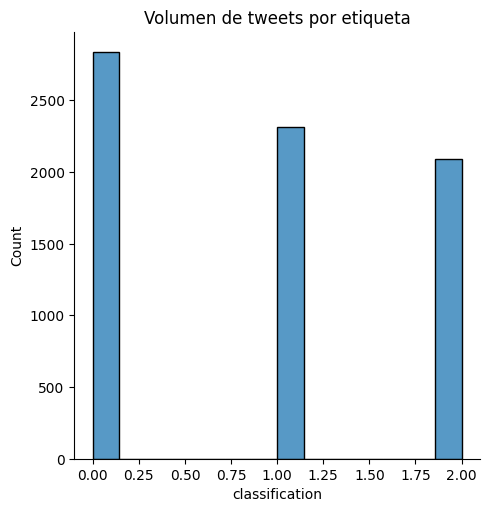

In [10]:
# Comprobamos distribución de la etiqueta 'classification'
sns.displot(df_initial.classification)
plt.title('Volumen de tweets por etiqueta');
print(df_initial.classification.value_counts())
print('Tamaño del dataset:', df_initial.shape)

(0.0, 40.0)

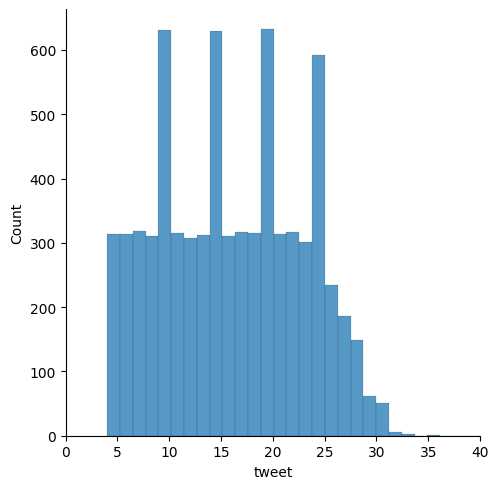

In [11]:
def count_words(df):
    count = 0
    for word in df.split():
        count += 1
    return count
#------------------------------------------------------------------------------------#
## recortar el eje x hasta 100 para mejorar la visualizacion.
ax = sns.displot(df_initial['tweet'].apply(count_words))
plt.xlim(0,40)

### Funciones para tratamiento de datos


* Debemos tener que estos tweets no están normalizados y por lo tanto debemos diseñar funciones que no permitan normalizar las expreciones escritas, quitar, emojis y corregir algunas otras cosas para no tener palabras que aunque signifiquen lo mismo parezcan diferentes.

In [12]:
# Eliminamos signos de puntuación y sustituimos por espacios en blanco

def remove_punctuation_space(df):
    PUNCTUATION = re.compile("""(\-)|(\,)|(\..)|(\...)|(\....)|(\.....)|(\......)|(\.......)""")
    
    return " ".join([PUNCTUATION.sub(" ", word.lower()) for word in df.split()])

In [13]:
# Eliminamos signos de puntuación sin reemplazo

def remove_punctuation(df):
    PUNCTUATION = re.compile("""(\.)|(\;)|(\:)|(\!)|(\?)|(\¡)|(\¿)| \
    (\")|(\()|(\))|(\[)|(\])|(\d+)|(\/)|(\“)|(\”)|(\')|(\-)|(\")|(\*)""")
    
    return " ".join([PUNCTUATION.sub("", word.lower()) for word in df.split()])

In [14]:
# Corregimos abreviaciones
def fix_abbr(x):
    if type(x) == list:
        words = x
    elif type(x) == str:
        words = x.split()
    else:
        raise TypeError('El formato no es válido, debe ser lista o str')

    abbrevs = {'d': 'de',
               'x': 'por',
               'xa': 'para',
               'as': 'has',
               'q': 'que',
               'k': 'que',
               'dl': 'del',
               'xq': 'porqué',
               'dr': 'doctor',
               'dra': 'doctora',
               'sr': 'señor',
               'sra': 'señora',
               'm': 'me'}
    return " ".join([abbrevs[word] if word in abbrevs.keys() else word for word in words])

In [15]:

# Sustituimos links por {link}
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

In [16]:
# Eliminamos vocales repetidas
    
def remove_repeated_vocals(df):
    
    list_new_word = []

    for word in df.split(): #separamos en palabras
        new_word = []
        pos = 0
        
        for letra in word: #separamos cada palabra en letras
            #print(word, letra, pos, '-', new_word)
            if pos>0:
                if letra in ('a', 'e', 'i', 'o', 'u') and letra == new_word[pos-1]:
                    None
                else:
                    new_word.append(letra)
                    pos +=1
            else:
                new_word.append(letra)
            
                pos += 1
        else:
            list_new_word.append("".join(new_word))
                
    return " ".join(list_new_word)

In [17]:
# Normalizamos risas 'jajaja', 'jejeje', 'jojojo'
    
def normalize_laughts(df):
    
    list_new_words = []
    for word in df.split(): #separamos en palabras
        count = 0
        vocals_dicc = {'a': 0, 'e': 0, 'i': 0, 'o':0, 'u':0}
        
        for letra in word:
            #print(word)
            if letra == 'j':
                count+=1
            if letra in vocals_dicc.keys():
                vocals_dicc[letra] += 1
        else:
            if count>3:
                dicc_risa = {'a': 'jaja', 'e': 'jeje', 'i': 'jiji', 'o': 'jojo', 'u': 'juju'}
                risa_type = max(vocals_dicc, key= lambda x: vocals_dicc[x]) #Indica si es a,e,i,o,u
                list_new_words.append(dicc_risa[risa_type])
            else:
                list_new_words.append(word)
    
    return " ".join(list_new_words)

In [18]:
# Sustituimos hashtag por {hash}
def remove_hashtags(df):
    return " ".join(['{hash}' if word.startswith('#') else word for word in df.split()])

In [19]:
# Sustituimos menciones por {mencion}
def remove_mentions(df):
    return " ".join(['{menc}' if word.startswith('“@') or word.startswith('@') else word for word in df.split()])

In [20]:
# Función para identificar los 'emojis' tradicionales

def transform_icons(df):
    word_list = []
    pos_emojis = [':)', ':D', ':))', ':)))', 'xD', 'xd', 'XD']
    neg_emojis = [':(', ":'(", '>:(', ':,(', ":(("]
    for word in df.split():
        if word in neg_emojis:
            word = '{emoji_neg}'
            word_list.append(word)
        elif word in pos_emojis:
            word = '{emoji_pos}'
            word_list.append(word)
        elif ':O' in word:
            word = '{emoji_neu}'
            word_list.append(word)
        else:
            word_list.append(word)
    return " ".join(word_list)

In [21]:
# Separamos emojis que vengan juntos
def sep_emojis(df):
    words_list = []
    for token in df.split():
        new_word = []
        for letra in token:
            if letra in emoji.UNICODE_EMOJI['es']:
                words_list.append(letra)
            else:
                new_word.append(letra)
        else:
            words_list.append("".join(new_word))

    return (" ".join(word for word in words_list if word != ''))

In [22]:
# Eliminamos stopwords
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')
non_stopwords = ['no', 'ni', 'poco', 'mucho', 'nada', 'muchos', 'muy', 'nosotros',
                 'nosotras', 'vosotros', 'vosotras', 'ellos', 'ellas', 'ella', 'él', 'tu', 'tú', 'yo',
                 'pero', 'hasta', 'contra', 'por']
spanish_stopwords = [word for word in stopwords.words('spanish') if word not in non_stopwords]

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Función para stemizar
def stem(df):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in df.split()])

In [24]:
# Función para lematizar
# Creamos el objeto
spacy.prefer_gpu() # or spacy.require_gpu()
nlp = spacy.load("es_core_news_md")


# Definimos función
def lemmatizer(df):
    word_list = []
    doc = nlp(df)
    for tok in doc:
        if str(tok) == 'menc':
              word_list.append('{menc}')
        elif str(tok) == 'hash':
              word_list.append('{hash}')
        elif str(tok) == 'link':
              word_list.append('{link}')
        elif str(tok) == 'emoji_pos':
              word_list.append('{emoji_pos}')
        elif str(tok) == 'emoji_neu':
              word_list.append('{emoji_neu}')
        elif str(tok) == 'emoji_neg':
              word_list.append('{emoji_neg}')
        elif str(tok) == 'eur':
              word_list.append('{eur}')
        else:
            word_list.append(tok.lemma_.lower())

    return " ".join([word for word in word_list if (word != '{') and (word!='}')])  

In [25]:
# Función para corregir las palabras

spell = SpellChecker(language='es', distance=1)

def correcting_words(df):
    misspelled = spell.unknown(df.split())
    return " ".join(filter(None,[spell.correction(word) if word in misspelled else word for word in df.split()]))

In [26]:
def remove_eur(df):
    wlist = ['{eur}' if ('€' in word) | ('euro' in word) | ('$' in word) else word for word in df.split()]
    return " ".join(wlist)

In [27]:
# Put it all together

def transform_tweets(df, mode='lemma'):
    
    df = remove_links(df)
    df = remove_punctuation_space(df)
    df = remove_mentions(df)    
    df = remove_hashtags(df)
    df = remove_eur(df)
    df = transform_icons(df)
    df = sep_emojis(df)
    df = normalize_laughts(df)
    df = remove_punctuation(df)
    df = remove_repeated_vocals(df)
    df = correcting_words(df)
    df = fix_abbr(df)
    df = remove_stopwords(df)
    if mode=='lemma':
        df = lemmatizer(df)
    elif mode=='stem':
        df = stem(df)
    else:
        raise TypeError('Invalid mode. Must be "lemma" or "stem"') 
    df = remove_stopwords(df)                    
    return df

El stemizado es mejor para usar en ingles, es mejor el lemetizado para lenguas romance

In [28]:
print('Tweet original:\n', df_initial.tweet[50:51].iloc[0])
print('Tweet lematizado:\n', df_initial.tweet[50:51].apply(transform_tweets, mode='lemma').iloc[0])
print('Tweet stemizado:\n',df_initial.tweet[50:51].apply(transform_tweets, mode='stem').iloc[0])

Tweet original:
 Nos encanta hacerte feliz @rubndu
Tweet lematizado:
 encantar hacer tú feliz
Tweet stemizado:
 encant hacert feliz


In [29]:
%%time
# Aplicamos
df_initial['tweet_'] = df_initial.tweet.apply(transform_tweets, mode='lemma')
df_final['tweet_'] = df_final.tweet.apply(transform_tweets, mode='lemma')

CPU times: total: 39.1 s
Wall time: 55.1 s


In [30]:
from pysentimiento import SentimentAnalyzer
analyzer = SentimentAnalyzer(lang="es")
from pysentimiento.preprocessing import preprocess_tweet
tweet_2 = []
for i in range(df_initial.shape[0]):
    tweet_2.append(preprocess_tweet(df_initial.tweet[i:i+1]))
df_initial['tweet_2'] = tweet_2
tweet_2_pred = []
for i in range(df_final.shape[0]):
    tweet_2_pred.append(preprocess_tweet(df_final.tweet[i:i+1]))
df_final['tweet_2'] = tweet_2_pred

In [31]:
df_all = pd.concat([df_initial,df_final])

In [32]:
df_all.head()

,id,tweet,classification,tweet_,tweet_2
0,809927403615256576,En definitiva! Me quedé sin campo para ir a Ta...,0,definitivo quedar campo ir mentalizado hasta q...,En definitiva! Me quedé sin campo para ir a Ta...
1,796040775364710400,@dianalaa32 Es una escena de uno de los docume...,2,escena documental respetado naturaleza planet ...,@usuario Es una escena de uno de los documenta...
2,802912779854352384,Qué feo es tener que terminar con alguien; y m...,0,feo tener terminar alguien dos persona aún ama...,Qué feo es tener que terminar con alguien; y m...
3,800835505717972992,"Oído en McDonalds ""el mejor mannequin challeng...",0,oer mcdonalds mejor challenge visto hasta ahor...,"Oído en McDonalds ""el mejor mannequin challeng..."
4,791640101751230464,Tengo que aceptar que me esta hundiendo el con...,1,aceptar hundir consumismo nuevo pro gorro hero...,Tengo que aceptar que me esta hundiendo el con...


In [33]:
# Creamos X,y

X = df_all['tweet_']
y = df_all.classification

# Creamos train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    test_size = 0.3)

# Modelos 

In [34]:

y_test_binarize = label_binarize(y_test,classes=[0,1,2])
# Vectorizamos
from sklearn.feature_extraction.text import CountVectorizer

# Creamos objeto y entrenamos
df_vectorizer = CountVectorizer(binary = True,
                                      ngram_range=(1, 3))
df_vectorizer.fit(X_train)

# Transformamos X en sparse vector
X_train_vec = df_vectorizer.transform(X_train)
X_test_vec = df_vectorizer.transform(X_test)

## Algoritmos Clásicos de clasificación

### Regresión Logistica

1 los dableje en luga5 de 5 10
2 un rango mas amplio para el parametro C de a 1 a 10 
si tenemos un mensaje de no convergencia tenemo que ponemos mas iteraciones
cambiar el scoring por f1 

In [35]:
clf_LR = LogisticRegression(C = 1.5 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0).fit(X_train_vec, y_train)
y_pred_log_reg_cv_proba = clf_LR.predict_proba(X_test_vec)
y_pred_log_reg_cv = clf_LR.predict(X_test_vec)

comparacion entre predict_proba y el predic para revisar la si hay cambios significantes en los resultados.

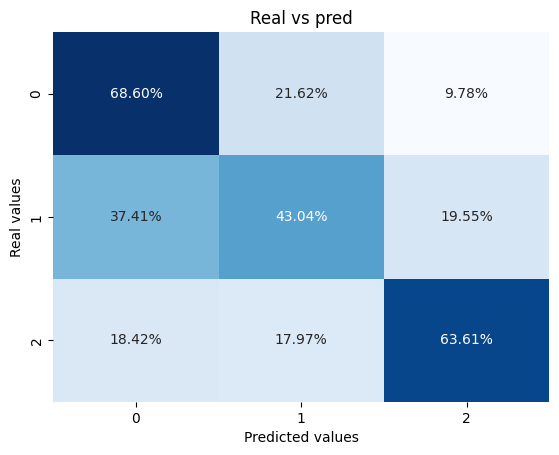

In [36]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg_cv, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

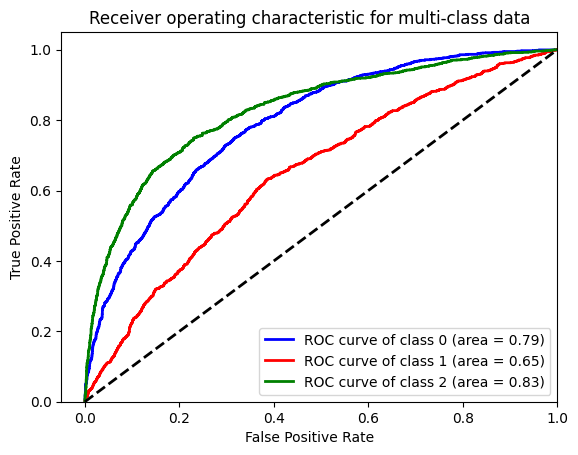

In [37]:
# Compute ROC curve and ROC area for each class
n_classes = 3
y_score = clf_LR.decision_function(X_test_vec)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [38]:
ct_lr = ['regresion_logistica','CountVectorizer',accuracy_score(y_test, y_pred_log_reg_cv),f1_score(y_test, y_pred_log_reg_cv, average='macro'),
         precision_score(y_test, y_pred_log_reg_cv,average='macro'),balanced_accuracy_score(y_test, y_pred_log_reg_cv),
         roc_auc_score(y_test, clf_LR.predict_proba(X_test_vec),multi_class='ovr')]
ct_lr

['regresion_logistica',
 'CountVectorizer',
 0.5975189524465886,
 0.5853926946556567,
 0.5882127527176674,
 0.5841705993872381,
 0.7630518379524038]

In [39]:
# Sacamos matriz de correlación
print(classification_report(y_test, y_pred_log_reg_cv))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66      1758
           1       0.46      0.43      0.45      1243
           2       0.67      0.64      0.65      1352

    accuracy                           0.60      4353
   macro avg       0.59      0.58      0.59      4353
weighted avg       0.60      0.60      0.60      4353



### SVC

In [40]:
pipe_lin_svc = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svc', LinearSVC())
])
pipe_lin_svc_params = dict(svc__C = [0.01, 0.1, 0.25, 0.5, 1, 1.5])

lin_svc_cv = GridSearchCV(pipe_lin_svc,
                          pipe_lin_svc_params,
                          cv = 10,
                          n_jobs = -1,
                          scoring = 'f1')
lin_svc_cv.fit(X_train_vec, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('svc', LinearSVC())]),
             n_jobs=-1, param_grid={'svc__C': [0.01, 0.1, 0.25, 0.5, 1, 1.5]},
             scoring='f1')

In [41]:
lin_svc_cv.best_params_

{'svc__C': 0.01}

In [42]:
# Predecimos

y_pred_lin_svc_cv = lin_svc_cv.predict(X_test_vec)
accuracy_lin_svc_cv = accuracy_score(y_test, y_pred_lin_svc_cv)
accuracy_lin_svc_cv

0.5283712382265104

In [43]:
ct_svc_lineal = ['scv_lineal','CountVectorizer',accuracy_score(y_test, y_pred_lin_svc_cv), f1_score(y_test, y_pred_lin_svc_cv, average='macro'),
          precision_score(y_test, y_pred_lin_svc_cv,average='macro'),balanced_accuracy_score(y_test, y_pred_lin_svc_cv),
          0]
ct_svc_lineal

['scv_lineal',
 'CountVectorizer',
 0.5283712382265104,
 0.5281961714249679,
 0.5356513706986402,
 0.5289121119092403,
 0]

In [44]:
# Sacamos matriz de correlación
print(classification_report(y_test, y_pred_lin_svc_cv))

              precision    recall  f1-score   support

           0       0.62      0.51      0.56      1758
           1       0.38      0.49      0.43      1243
           2       0.60      0.58      0.59      1352

    accuracy                           0.53      4353
   macro avg       0.54      0.53      0.53      4353
weighted avg       0.55      0.53      0.53      4353



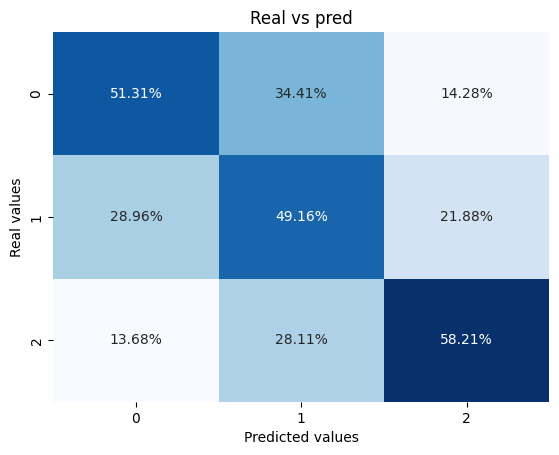

In [45]:
#display_cm(y_test, y_pred_rf_cv)

sns.heatmap(confusion_matrix(y_test,y_pred_lin_svc_cv, normalize = 'true'),
            annot=True,fmt='.2%' ,cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

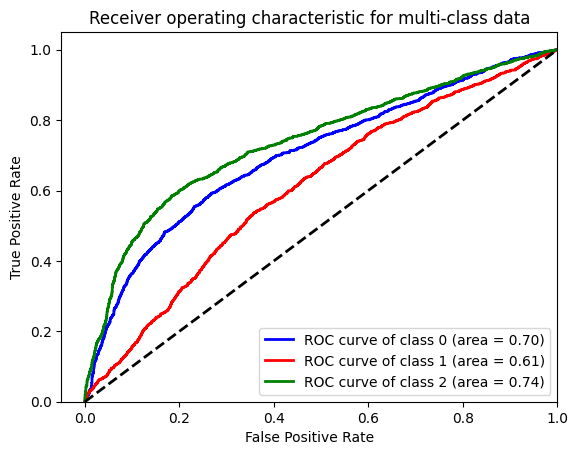

In [46]:
n_classes = 3
y_score = lin_svc_cv.decision_function(X_test_vec)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### GaussianNB

In [47]:
clf_GN = GaussianNB()
clf_GN.fit(X_train_vec.toarray(), y_train)
y_pred_clf_GN = clf_GN.predict(X_test_vec.toarray())

In [48]:
print(classification_report(y_test,y_pred_clf_GN))

              precision    recall  f1-score   support

           0       0.56      0.39      0.46      1758
           1       0.34      0.32      0.33      1243
           2       0.44      0.63      0.51      1352

    accuracy                           0.44      4353
   macro avg       0.44      0.45      0.43      4353
weighted avg       0.46      0.44      0.44      4353



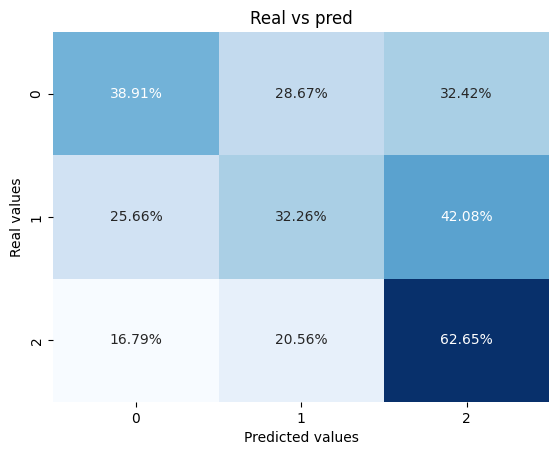

In [49]:
sns.heatmap(confusion_matrix(y_test, y_pred_clf_GN, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

In [50]:
ct_GauNB = ['GaussianNB','CountVectorizer',accuracy_score(y_test, y_pred_clf_GN), f1_score(y_test, y_pred_clf_GN, average='macro'),
            precision_score(y_test, y_pred_clf_GN,average='macro'),balanced_accuracy_score(y_test, y_pred_clf_GN),
            roc_auc_score(y_test,clf_GN.predict_proba(X_test_vec.toarray()),multi_class='ovr')]
ct_GauNB

['GaussianNB',
 'CountVectorizer',
 0.44383184011026877,
 0.43433248429474114,
 0.44388807423468263,
 0.4460547950590746,
 0.5853501477008776]

# Otro algoritmos de clasificación

Metodo de ensamble 

Gradient boosting
knn 
Bayes Gaussiano. 


Cuando utilicemos otras arquitecturas debemos cambiar las medidas


## Métodos de Ensamble

### Random Forest

Barrido de n_estimator = 100 hasta 400 aumentos de 50 
max_depth ---> 2,10 incremtos de 2
min_samples_leaf ----1,2,3
criterion ----> “gini”, “entropy”
class_weight--> “balanced”, “balanced_subsample []

In [51]:
random_forest_cv = RandomForestClassifier(class_weight= 'balanced_subsample',
 criterion= 'entropy',
 max_depth= 10,
 min_samples_leaf= 1,
 n_estimators= 350,random_state= 123)
random_forest_cv.fit(X_train_vec, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, n_estimators=350, random_state=123)

In [52]:
y_pred_rf_cv = random_forest_cv.predict(X_test_vec)
print(classification_report(y_test, y_pred_rf_cv))

              precision    recall  f1-score   support

           0       0.64      0.63      0.63      1758
           1       0.43      0.45      0.44      1243
           2       0.65      0.63      0.64      1352

    accuracy                           0.58      4353
   macro avg       0.57      0.57      0.57      4353
weighted avg       0.58      0.58      0.58      4353



In [53]:
ct_rf = ['RandomForest','CountVectorizer',accuracy_score(y_test, y_pred_rf_cv),f1_score(y_test, y_pred_rf_cv, average='macro'),
         precision_score(y_test, y_pred_rf_cv,average='macro'),balanced_accuracy_score(y_test, y_pred_rf_cv),
         roc_auc_score(y_test, random_forest_cv.predict_proba(X_test_vec),multi_class='ovr')]
ct_rf

['RandomForest',
 'CountVectorizer',
 0.5793705490466345,
 0.5719907666710409,
 0.5733487691700229,
 0.5709925361336087,
 0.7443063421256925]

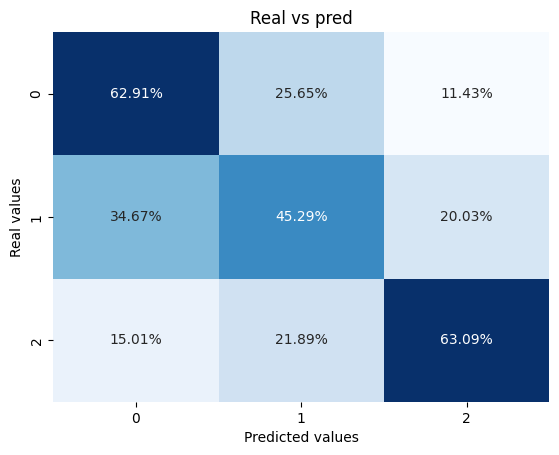

In [54]:
y_pred_rf_cv = random_forest_cv.predict(X_test_vec)
sns.heatmap(confusion_matrix(y_test, y_pred_rf_cv, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

## HistGradientBoostingClassifier

In [55]:
clf_hgb = HistGradientBoostingClassifier()
clf_hgb.fit(X_train_vec.toarray(), y_train)
y_pred_clf_hgb = clf_hgb.predict(X_test_vec.toarray())

In [56]:
print(classification_report(y_test, y_pred_clf_hgb))

              precision    recall  f1-score   support

           0       0.58      0.69      0.63      1758
           1       0.40      0.34      0.37      1243
           2       0.67      0.60      0.63      1352

    accuracy                           0.56      4353
   macro avg       0.55      0.54      0.54      4353
weighted avg       0.56      0.56      0.56      4353



In [57]:
ct_HBG = ['HistGradientBoostingClassifier','CountVectorizer',accuracy_score(y_test, y_pred_clf_hgb),f1_score(y_test, y_pred_clf_hgb, average='macro')
          ,precision_score(y_test, y_pred_clf_hgb,average='macro'),balanced_accuracy_score(y_test, y_pred_clf_hgb),
          roc_auc_score(y_test,clf_hgb.predict_proba(X_test_vec.toarray()),multi_class= 'ovr')] 
ct_HBG

['HistGradientBoostingClassifier',
 'CountVectorizer',
 0.5614518722719963,
 0.5435252128073432,
 0.5501582129609718,
 0.5428212286024013,
 0.7410516654330435]

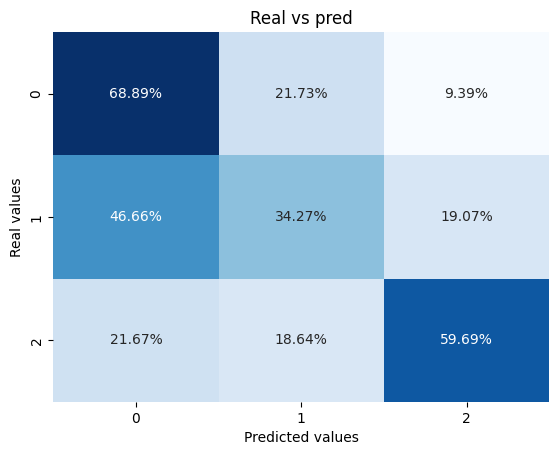

In [58]:
sns.heatmap(confusion_matrix(y_test,y_pred_clf_hgb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

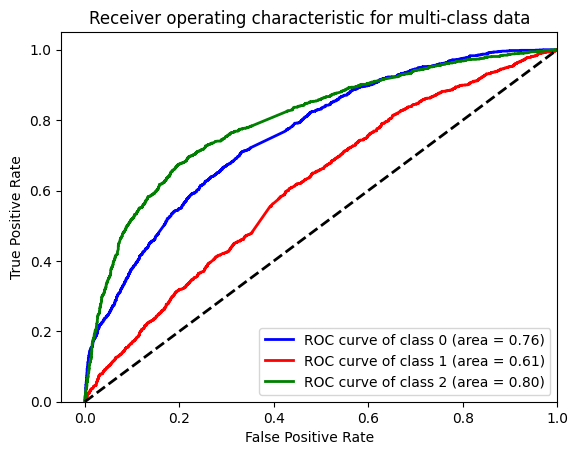

In [59]:
n_classes = 3
y_score = clf_hgb.decision_function(X_test_vec.toarray())
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### GradientBoostingClassifier

In [60]:
clf_GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train_vec, y_train)
y_predict_clf_GBC = clf_GBC.predict(X_test_vec)

In [61]:
print(classification_report(y_test, y_predict_clf_GBC))

              precision    recall  f1-score   support

           0       0.55      0.76      0.64      1758
           1       0.41      0.25      0.31      1243
           2       0.68      0.60      0.63      1352

    accuracy                           0.56      4353
   macro avg       0.55      0.53      0.53      4353
weighted avg       0.55      0.56      0.54      4353



In [62]:
ct_GBc = ['GradientBoostingClassifier','CountVectorizer',accuracy_score(y_test,y_predict_clf_GBC),
          f1_score(y_test, y_predict_clf_GBC, average='macro'),precision_score(y_test, y_predict_clf_GBC,average='macro'),
          balanced_accuracy_score(y_test, y_predict_clf_GBC),roc_auc_score(y_test,clf_GBC.predict_proba(X_test_vec),multi_class='ovr')]
ct_GBc

['GradientBoostingClassifier',
 'CountVectorizer',
 0.5616815988973122,
 0.5273252830615451,
 0.5461054034653897,
 0.533819434406249,
 0.7409874385808507]

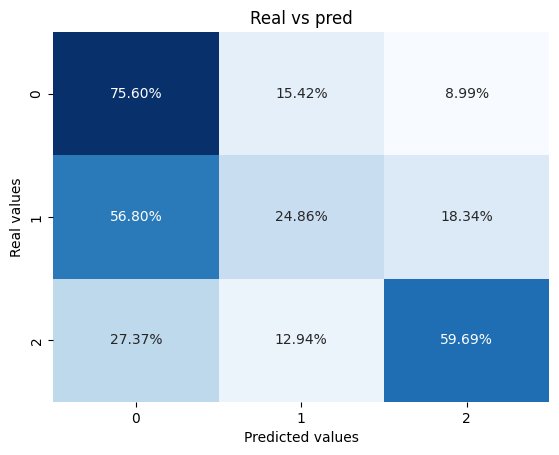

In [63]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_GBC, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

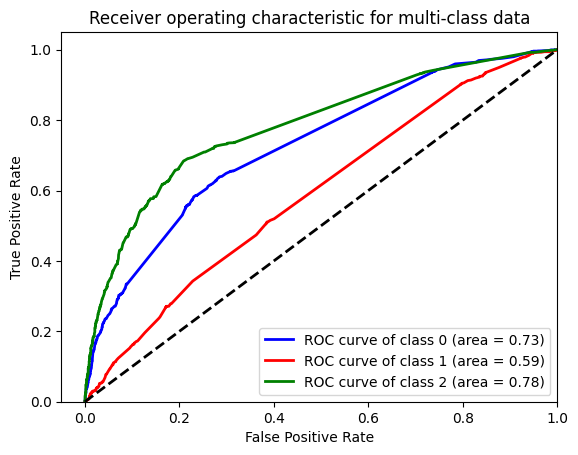

In [64]:
n_classes = 3
y_score = clf_GBC.decision_function(X_test_vec.toarray())
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### VotingClassifier

In [65]:
eclf2 = VotingClassifier(estimators=[
         ('lr', clf_LR ), ('rf', random_forest_cv ), ('GBC', clf_GBC),('HB', clf_hgb)],
         voting='soft')
eclf2 = eclf2.fit(X_train_vec.toarray(), y_train)
y_predict_clf_VT= eclf2.predict(X_test_vec.toarray())

In [66]:
try:
 ct_VC = ['VotingClassifier','CountVectorizer',accuracy_score(y_test,y_predict_clf_VT),f1_score(y_test,y_predict_clf_VT,average='macro')
         ,precision_score(y_test,y_predict_clf_VT,average='macro'),balanced_accuracy_score(y_test,y_predict_clf_VT),
         roc_auc_score(y_test,eclf2.predict_proba(X_test_vec.toarray()),multi_class='ovr')]
except :
  ct_VC = ['VotingClassifier','CountVectorizer',accuracy_score(y_test,y_predict_clf_VT),f1_score(y_test,y_predict_clf_VT,average='macro')
         ,precision_score(y_test,y_predict_clf_VT,average='macro'),balanced_accuracy_score(y_test,y_predict_clf_VT),
        0]

ct_VC

['VotingClassifier',
 'CountVectorizer',
 0.596600045945325,
 0.5808647427037837,
 0.5868205909624558,
 0.5797415086136838,
 0.7650018626963995]

In [67]:
print(classification_report(y_test, y_predict_clf_VT))

              precision    recall  f1-score   support

           0       0.61      0.71      0.66      1758
           1       0.46      0.39      0.42      1243
           2       0.69      0.64      0.66      1352

    accuracy                           0.60      4353
   macro avg       0.59      0.58      0.58      4353
weighted avg       0.59      0.60      0.59      4353



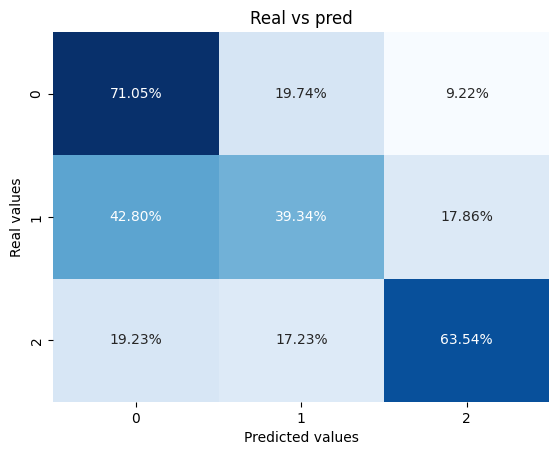

In [68]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_VT, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

### StackingClassifier

In [69]:
estimators = [('lr', LogisticRegression(C = 1.5 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0)),
('rf', RandomForestClassifier(class_weight= 'balanced_subsample',criterion= 'entropy', max_depth= 10, min_samples_leaf= 1, n_estimators= 350,random_state= 123)),
('GB',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0))]
clf_SC = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [70]:
clf_SC.fit(X_train_vec, y_train)
y_predict_clf_SC= clf_SC.predict(X_test_vec)

In [71]:
print(classification_report(y_test, y_predict_clf_SC))

              precision    recall  f1-score   support

           0       0.63      0.72      0.67      1758
           1       0.46      0.39      0.42      1243
           2       0.68      0.64      0.66      1352

    accuracy                           0.60      4353
   macro avg       0.59      0.59      0.59      4353
weighted avg       0.60      0.60      0.60      4353



In [72]:
ct_StC = ['StackingClassifier','CountVectorizer',accuracy_score(y_test, y_predict_clf_SC),f1_score(y_test, y_predict_clf_SC,average='macro'),
          precision_score(y_test, y_predict_clf_SC,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_SC),
          roc_auc_score(y_test, clf_SC.predict_proba(X_test_vec),multi_class='ovr')]
ct_StC

['StackingClassifier',
 'CountVectorizer',
 0.6023432115782219,
 0.5854438448596924,
 0.5897071823731457,
 0.5851866308417746,
 0.7688384212536356]

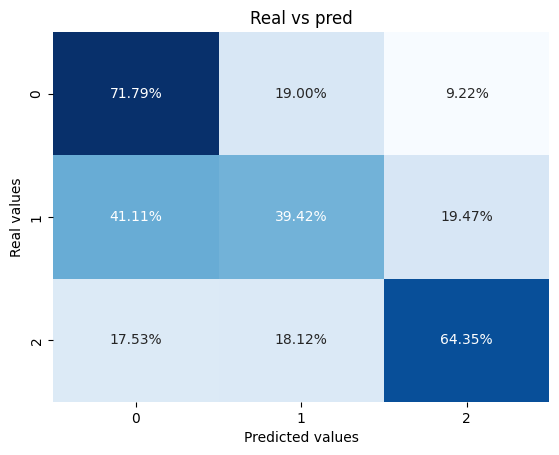

In [73]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_SC, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

XGrandientBoosting

In [74]:
import xgboost as xgb

In [75]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_xgbr = le.fit_transform(y_train)
y_test_xgbr =le.fit_transform(y_test)

In [76]:
xgbr_clf = xgb.XGBClassifier(booster = 'dart', eta = 0.5, gamma = 0.9 , learning_rate= 0.1,seed = 20)
xgbr_clf.fit(X_train_vec, y_train_xgbr)
y_clf_xgbr = xgbr_clf.predict(X_test_vec)

In [77]:
print(classification_report(y_test_xgbr, y_clf_xgbr))

              precision    recall  f1-score   support

           0       0.53      0.82      0.64      1758
           1       0.45      0.19      0.27      1243
           2       0.69      0.56      0.62      1352

    accuracy                           0.56      4353
   macro avg       0.56      0.53      0.51      4353
weighted avg       0.56      0.56      0.53      4353



In [78]:
ct_Xgbrt = ['XGBClassifier','CountVectorizer',accuracy_score(y_test_xgbr, y_clf_xgbr),f1_score(y_test_xgbr, y_clf_xgbr,average='macro'),
          precision_score(y_test_xgbr, y_clf_xgbr,average='macro'),balanced_accuracy_score(y_test_xgbr, y_clf_xgbr),
          roc_auc_score(y_test_xgbr, xgbr_clf.predict_proba(X_test_vec),multi_class='ovr')]
ct_Xgbrt

['XGBClassifier',
 'CountVectorizer',
 0.5619113255226281,
 0.5124881146820741,
 0.5587529266813119,
 0.5260694612811281,
 0.7410980222791931]

# Otro metodo de vectorizacion

In [79]:
# X_train, y_train = df_initial['tweet_'], df_initial['classification']
# X_test, y_test = df_final['tweet_'], df_final['classification']
# y_test_binarize = label_binarize(y_test,classes=[-1,0,1])
# Vectorizamos
from sklearn.feature_extraction.text import TfidfVectorizer

# Creamos objeto y entrenamos
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

# Transformamos X en sparse vector
X_train_vec_tf = vectorizer.transform(X_train)
X_test_vec_tf = vectorizer.transform(X_test)

## Algoritmos Clásicos de clasificación

### Regresión Logistica

In [80]:
clf_LR_tf = LogisticRegression(C = 0.25 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0).fit(X_train_vec_tf, y_train)
y_pred_log_reg_cv_proba_tf = clf_LR_tf.predict_proba(X_test_vec_tf)
y_pred_log_reg_cv_tf = clf_LR_tf.predict(X_test_vec_tf)

comparacion entre predict_proba y el predic para revisar la si hay cambios significantes en los resultados.

In [81]:
def get_label(probas, i=0.55):
    if np.argmax(probas)==0:
        return -1
    elif np.argmax(probas)==2:
        return 1
    elif np.argmax(probas)==1 and probas[1]<i:
        if probas[2] > probas[0]:
            return 1
        else:
            return -1
    else:
        return 0

y_new = np.array(list(map(lambda x: get_label(x), y_pred_log_reg_cv_proba)))

def interact_proba(i):
    plt.clf()
    
    y_new = np.array(list(map(lambda x: get_label(x, i), y_pred_log_reg_cv_proba)))
    
    # Evaluamos modelo
    sns.heatmap(confusion_matrix(y_test, y_new, normalize = 'true'),
                annot=True, fmt='g', cmap = 'Blues', cbar = False);

    plt.title("""Accuracy para cada clase en función
    del threshold controlado por el parámetro i""")
    plt.xlabel('Predicted values')
    plt.ylabel('Real values');

    plt.show()

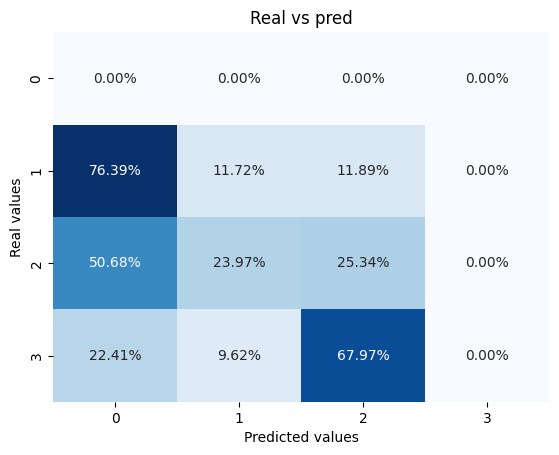

In [82]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_new, normalize = 'true'),
            annot=True,fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

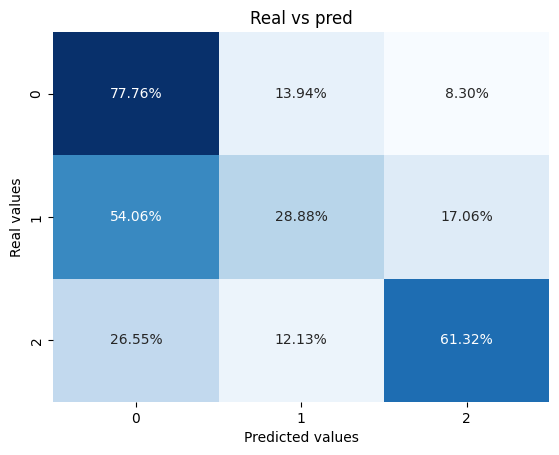

In [83]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg_cv_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

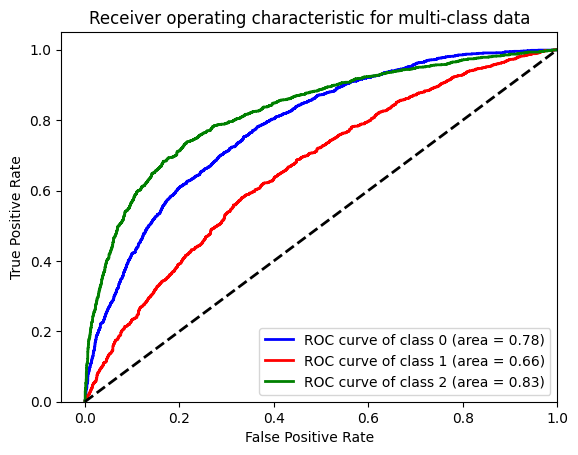

In [84]:
# Compute ROC curve and ROC area for each class
n_classes = 3
y_score = clf_LR_tf.decision_function(X_test_vec_tf)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [85]:
print(classification_report(y_test,y_pred_log_reg_cv_tf))

              precision    recall  f1-score   support

           0       0.57      0.78      0.66      1758
           1       0.47      0.29      0.36      1243
           2       0.70      0.61      0.65      1352

    accuracy                           0.59      4353
   macro avg       0.58      0.56      0.56      4353
weighted avg       0.58      0.59      0.57      4353



In [86]:
tfc_lr = ['LogisticRegression','TfidfVectorizer',accuracy_score(y_test, y_pred_log_reg_cv_tf),
          f1_score(y_test, y_pred_log_reg_cv_tf,average='macro'),precision_score(y_test, y_pred_log_reg_cv_tf,average='macro'),
          balanced_accuracy_score(y_test, y_pred_log_reg_cv_tf),roc_auc_score(y_test,clf_LR_tf.predict_proba(X_test_vec_tf),multi_class='ovr')]
tfc_lr

['LogisticRegression',
 'TfidfVectorizer',
 0.5869515276820584,
 0.5559644594793544,
 0.5786352082278893,
 0.5598570753864922,
 0.762918508144292]

### SVC

In [87]:
pipe_lin_svc = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svc', LinearSVC())
])
pipe_lin_svc_params = dict(svc__C = [0.01, 0.1, 0.25, 0.5, 1, 1.5])

lin_svc_cv_tf = GridSearchCV(pipe_lin_svc,
                          pipe_lin_svc_params,
                          cv = 10,
                          n_jobs = -1,
                          scoring = 'f1')
lin_svc_cv_tf.fit(X_train_vec_tf, y_train)
lin_svc_cv_tf.best_params_
y_pred_lin_svc_cv_tf = lin_svc_cv_tf.predict(X_test_vec_tf)


In [88]:
tfc_scv_lineal = ['LinearSVC','TfidfVectorizer',accuracy_score(y_test, y_pred_lin_svc_cv_tf),f1_score(y_test, y_pred_lin_svc_cv_tf,average='macro'),
                  precision_score(y_test, y_pred_lin_svc_cv_tf,average='macro'),balanced_accuracy_score(y_test, y_pred_lin_svc_cv_tf),
                  0]
tfc_scv_lineal

['LinearSVC',
 'TfidfVectorizer',
 0.4861015391683896,
 0.47961589250365383,
 0.4807207342219824,
 0.47945441153190843,
 0]

In [89]:
# Sacamos matriz de correlación
print(classification_report(y_test, y_pred_lin_svc_cv_tf))

              precision    recall  f1-score   support

           0       0.56      0.53      0.54      1758
           1       0.35      0.38      0.37      1243
           2       0.53      0.53      0.53      1352

    accuracy                           0.49      4353
   macro avg       0.48      0.48      0.48      4353
weighted avg       0.49      0.49      0.49      4353



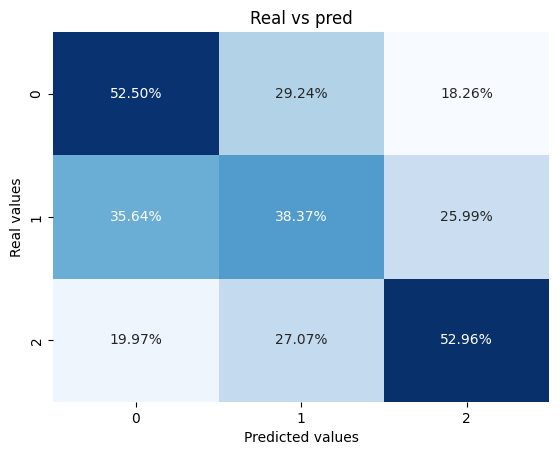

In [90]:
#display_cm(y_test, y_pred_rf_cv)

sns.heatmap(confusion_matrix(y_test,y_pred_lin_svc_cv_tf, normalize = 'true'),
            annot=True,fmt='.2%' ,cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

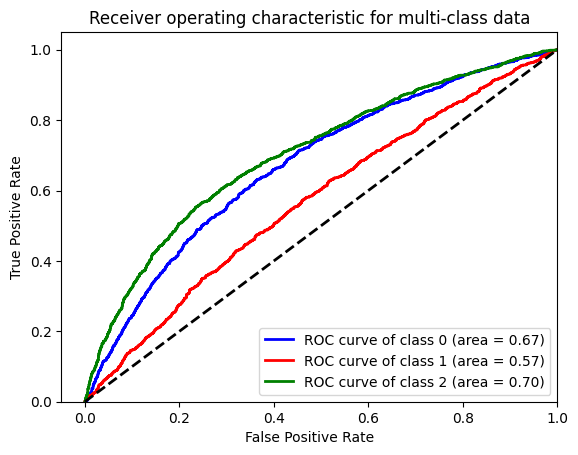

In [91]:
n_classes = 3
y_score = lin_svc_cv_tf.decision_function(X_test_vec_tf)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### GaussianNB

In [92]:
clf_GN_tf = GaussianNB()
clf_GN_tf.fit(X_train_vec_tf.toarray(), y_train)
y_pred_clf_GN_tf = clf_GN_tf.predict(X_test_vec_tf.toarray())

In [93]:
print(classification_report(y_test,y_pred_clf_GN_tf))

              precision    recall  f1-score   support

           0       0.53      0.27      0.36      1758
           1       0.31      0.27      0.29      1243
           2       0.38      0.67      0.48      1352

    accuracy                           0.39      4353
   macro avg       0.41      0.40      0.37      4353
weighted avg       0.42      0.39      0.37      4353



In [94]:
tfc_GaussianNb = ['GaussianNB','TfidfVectorizer',accuracy_score(y_test, y_pred_clf_GN_tf),f1_score(y_test, y_pred_clf_GN_tf,average='macro'),
                  precision_score(y_test, y_pred_clf_GN_tf,average='macro'),balanced_accuracy_score(y_test, y_pred_clf_GN_tf),
                  roc_auc_score(y_test, clf_GN_tf.predict_proba(X_test_vec_tf.toarray()),multi_class='ovr')]
tfc_GaussianNb

['GaussianNB',
 'TfidfVectorizer',
 0.3912244429129336,
 0.3744613519047551,
 0.40501886838946327,
 0.40023143274408907,
 0.5508348420442689]

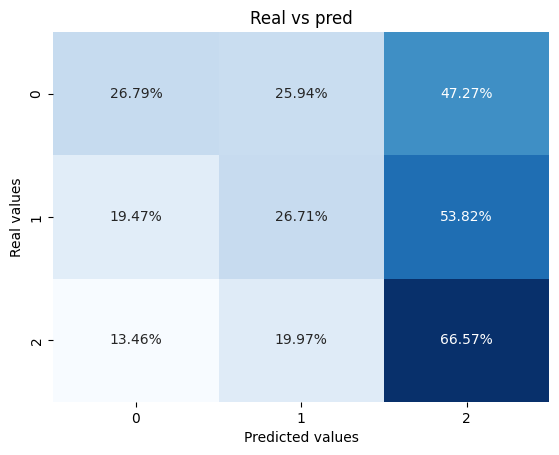

In [95]:
sns.heatmap(confusion_matrix(y_test, y_pred_clf_GN_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

## Métodos de Ensamble

### Random Forest

Barrido de n_estimator = 100 hasta 400 aumentos de 50 
max_depth ---> 2,10 incremtos de 2
min_samples_leaf ----1,2,3
criterion ----> “gini”, “entropy”
class_weight--> “balanced”, “balanced_subsample []

In [96]:
random_forest_cv_tf = RandomForestClassifier(class_weight= 'balanced_subsample',
 criterion= 'gini',
 max_depth= 10,
 min_samples_leaf= 3,
 n_estimators= 350,random_state= 123)
random_forest_cv_tf.fit(X_train_vec_tf, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_leaf=3, n_estimators=350, random_state=123)

In [97]:
y_pred_rf_cv_tf = random_forest_cv_tf.predict(X_test_vec_tf)
print(classification_report(y_test, y_pred_rf_cv_tf))

              precision    recall  f1-score   support

           0       0.66      0.57      0.61      1758
           1       0.43      0.53      0.48      1243
           2       0.64      0.62      0.63      1352

    accuracy                           0.57      4353
   macro avg       0.58      0.57      0.57      4353
weighted avg       0.59      0.57      0.58      4353



In [98]:
tfc_rf = ['RandomForest','TfidfVectorizer',accuracy_score(y_test, y_pred_rf_cv_tf),f1_score(y_test, y_pred_rf_cv_tf,average='macro'),
                  precision_score(y_test, y_pred_rf_cv_tf,average='macro'),balanced_accuracy_score(y_test, y_pred_rf_cv_tf),
                  roc_auc_score(y_test, random_forest_cv_tf.predict_proba(X_test_vec_tf), multi_class='ovr')]
tfc_rf

['RandomForest',
 'TfidfVectorizer',
 0.5736273834137376,
 0.5719725122702357,
 0.5764598630198742,
 0.5729968206470645,
 0.7470031381324224]

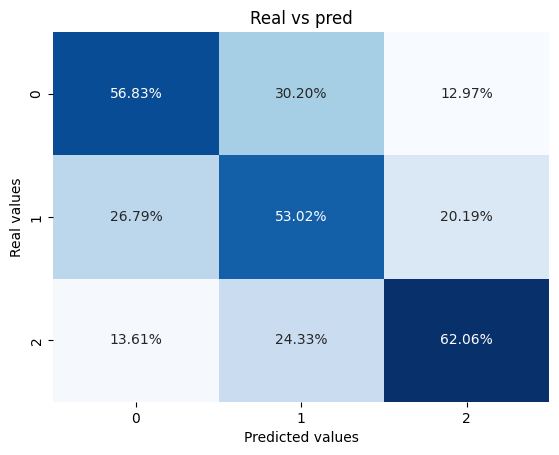

In [99]:
y_pred_rf_cv_tf = random_forest_cv_tf.predict(X_test_vec_tf)
sns.heatmap(confusion_matrix(y_test, y_pred_rf_cv_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

## HistGradientBoostingClassifier

In [100]:
clf_hgb_tf = HistGradientBoostingClassifier()
clf_hgb_tf.fit(X_train_vec_tf.toarray(), y_train)

y_pred_clf_hgb_tf = clf_hgb_tf.predict(X_test_vec_tf.toarray())


In [101]:
print(classification_report(y_test, y_pred_clf_hgb_tf))

              precision    recall  f1-score   support

           0       0.58      0.70      0.63      1758
           1       0.42      0.35      0.38      1243
           2       0.66      0.58      0.62      1352

    accuracy                           0.56      4353
   macro avg       0.55      0.54      0.54      4353
weighted avg       0.56      0.56      0.55      4353



In [102]:
tfc_HGB = ['HistGradientBoosting','TfidfVectorizer',accuracy_score(y_test, y_pred_lin_svc_cv),f1_score(y_test, y_pred_lin_svc_cv,average='macro'),
                  precision_score(y_test, y_pred_lin_svc_cv,average='macro'),balanced_accuracy_score(y_test, y_pred_lin_svc_cv),
                  roc_auc_score(y_test,clf_GN_tf.predict_proba(X_test_vec_tf.toarray()),multi_class='ovr')]
tfc_HGB

['HistGradientBoosting',
 'TfidfVectorizer',
 0.5283712382265104,
 0.5281961714249679,
 0.5356513706986402,
 0.5289121119092403,
 0.5508348420442689]

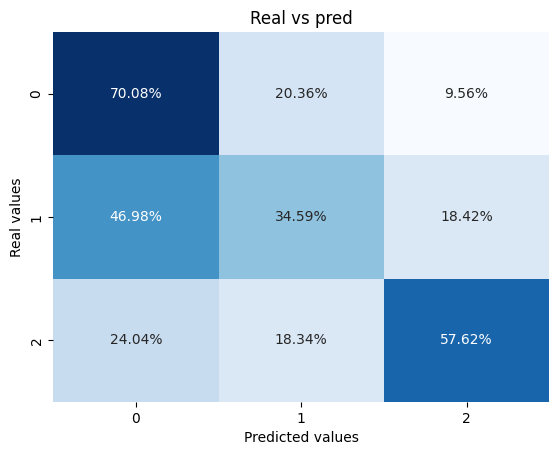

In [103]:
sns.heatmap(confusion_matrix(y_test,y_pred_clf_hgb_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

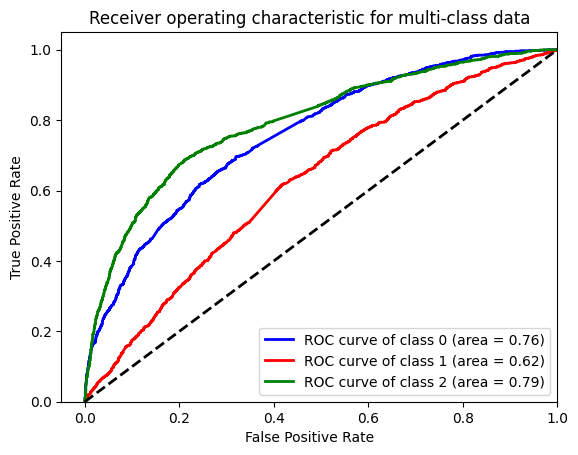

In [104]:
n_classes = 3
y_score = clf_hgb_tf.decision_function(X_test_vec_tf.toarray())
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### GradientBoostingClassifier

In [105]:
clf_GBC_tf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train_vec_tf, y_train)
y_predict_clf_GBC_tf = clf_GBC_tf.predict(X_test_vec_tf)

In [106]:
print(classification_report(y_test, y_predict_clf_GBC_tf))

              precision    recall  f1-score   support

           0       0.56      0.73      0.63      1758
           1       0.43      0.30      0.35      1243
           2       0.67      0.58      0.62      1352

    accuracy                           0.56      4353
   macro avg       0.55      0.54      0.53      4353
weighted avg       0.55      0.56      0.55      4353



In [107]:
tfc_GBC = ['GradientBoosting','TfidfVectorizer',accuracy_score(y_test, y_predict_clf_GBC_tf),f1_score(y_test, y_predict_clf_GBC_tf,average='macro'),
                  precision_score(y_test, y_predict_clf_GBC_tf,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_GBC_tf),
                  roc_auc_score(y_test,clf_GBC_tf.predict_proba(X_test_vec_tf),multi_class='ovr')]
tfc_GBC

['GradientBoosting',
 'TfidfVectorizer',
 0.5598437858947852,
 0.5342585373091816,
 0.5498914898565553,
 0.5359421813593,
 0.736669872244102]

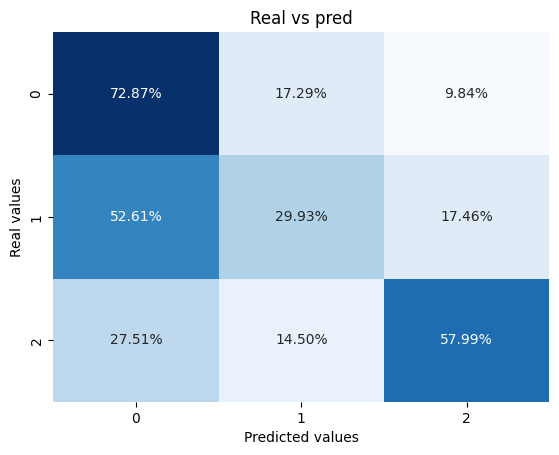

In [108]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_GBC_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

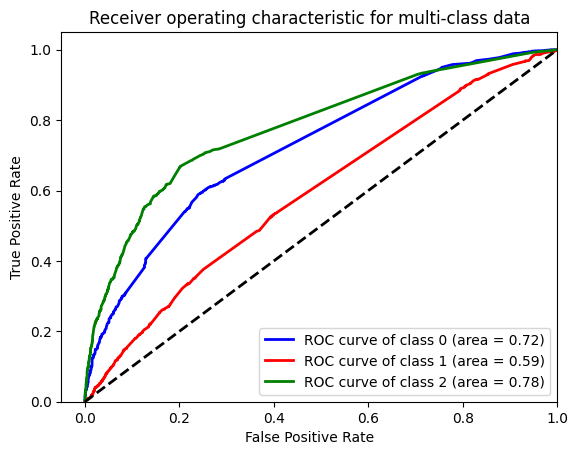

In [109]:
n_classes = 3
y_score = clf_GBC_tf.decision_function(X_test_vec_tf.toarray())
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### VotingClassifier

In [110]:
eclf2_tf = VotingClassifier(estimators=[
         ('lr', clf_LR_tf ), ('rf', random_forest_cv_tf ), ('HB', clf_hgb_tf)],
         voting='hard')
eclf2_tf = eclf2_tf.fit(X_train_vec_tf.toarray(), y_train)
y_predict_clf_VT_tf = eclf2_tf.predict(X_test_vec_tf.toarray())

In [111]:
print(classification_report(y_test, y_predict_clf_VT_tf))

              precision    recall  f1-score   support

           0       0.59      0.72      0.64      1758
           1       0.46      0.37      0.41      1243
           2       0.69      0.61      0.65      1352

    accuracy                           0.58      4353
   macro avg       0.58      0.57      0.57      4353
weighted avg       0.58      0.58      0.58      4353



In [112]:
try:
    tfc_VC = ['VotingClassifer','TfidfVectorizer',accuracy_score(y_test, y_predict_clf_VT_tf),f1_score(y_test, y_predict_clf_VT_tf,average='macro'),
                  precision_score(y_test, y_predict_clf_VT_tf,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_VT_tf),
                  roc_auc_score(y_test,eclf2_tf.predict_proba(X_test_vec_tf),multi_class='ovr')]
except:
    tfc_VC = ['VotingClassifer','TfidfVectorizer',accuracy_score(y_test, y_predict_clf_VT_tf),f1_score(y_test, y_predict_clf_VT_tf,average='macro'),
                  precision_score(y_test, y_predict_clf_VT_tf,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_VT_tf),
                  0]
tfc_VC

['VotingClassifer',
 'TfidfVectorizer',
 0.5844245348035837,
 0.5669014691654879,
 0.577463014712218,
 0.5654564556925523,
 0]

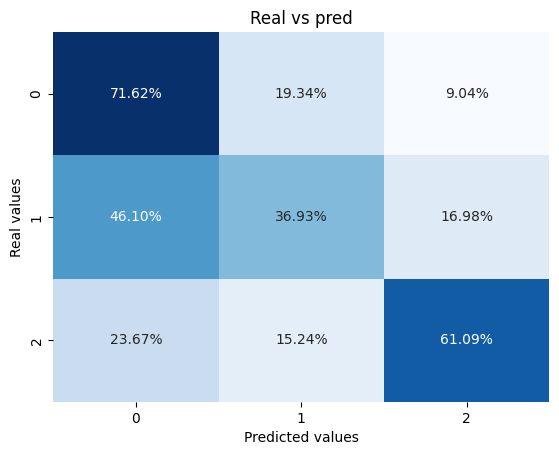

In [113]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_VT_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

### StackingClassifier

In [114]:
estimators_tf = [('lr', LogisticRegression(C = 1.5 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0)),
('rf', RandomForestClassifier(class_weight= 'balanced_subsample',criterion= 'entropy', max_depth= 10, min_samples_leaf= 1, n_estimators= 350,random_state= 123)),
('GB',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0))]
clf_SC_tf = StackingClassifier(estimators=estimators_tf, final_estimator=LogisticRegression())

In [115]:
clf_SC_tf.fit(X_train_vec_tf, y_train)
y_predict_clf_SC_tf= clf_SC_tf.predict(X_test_vec_tf)

In [116]:
print(classification_report(y_test, y_predict_clf_SC_tf))

              precision    recall  f1-score   support

           0       0.61      0.72      0.66      1758
           1       0.45      0.37      0.40      1243
           2       0.67      0.65      0.66      1352

    accuracy                           0.59      4353
   macro avg       0.58      0.58      0.57      4353
weighted avg       0.59      0.59      0.59      4353



In [117]:
tfc_StC = ['StackingClassifer','TfidfVectorizer',accuracy_score(y_test, y_predict_clf_SC_tf),f1_score(y_test, y_predict_clf_SC_tf,average='macro'),
                  precision_score(y_test, y_predict_clf_SC_tf,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_SC_tf),
                  roc_auc_score(y_test,clf_SC_tf.predict_proba(X_test_vec_tf),multi_class='ovr')]
tfc_StC

['StackingClassifer',
 'TfidfVectorizer',
 0.5936135998162188,
 0.5743914354449808,
 0.5791839018253703,
 0.5753241660376486,
 0.7682985490829353]

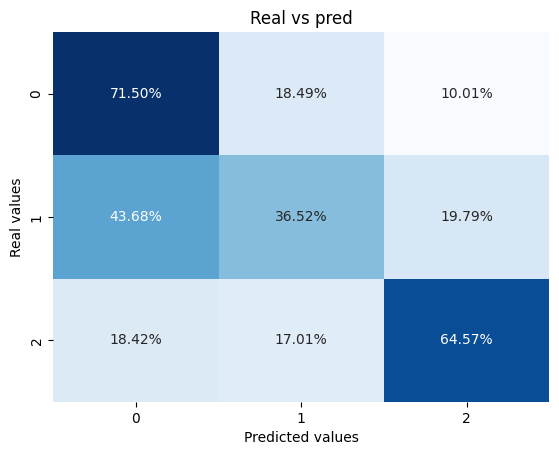

In [118]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_SC_tf, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

### XGrandient Boosting

In [119]:
params = { 'booster': ['dart'],
           'learning_rate': [0.01, 0.05],
           'eta': [0.5,0.7,0.9],
           'gamma': [0.3,0.5,0.7,0.9]}
xgbr = xgb.XGBClassifier(seed = 20)
clf_xgbr_tf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf_xgbr_tf.fit(X_train_vec_tf, y_train_xgbr)
print("Best parameters:", clf_xgbr_tf.best_params_)
#print("Lowest RMSE: ", (-clf_xgbr.best_score_)**(1/2.0))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'booster': 'dart', 'eta': 0.5, 'gamma': 0.3, 'learning_rate': 0.05}


In [120]:
clf_xgbr_tf.best_params_

{'booster': 'dart', 'eta': 0.5, 'gamma': 0.3, 'learning_rate': 0.05}

In [121]:
xgbr_clf_tf = xgb.XGBClassifier(booster = 'dart', eta = 0.5, gamma = 0.9 , learning_rate= 0.05,seed = 20)
xgbr_clf_tf.fit(X_train_vec_tf, y_train_xgbr)
y_clf_xgbr_tf = xgbr_clf_tf.predict(X_test_vec_tf)

In [122]:
print(classification_report(y_test_xgbr, y_clf_xgbr_tf))

              precision    recall  f1-score   support

           0       0.51      0.82      0.63      1758
           1       0.46      0.20      0.28      1243
           2       0.70      0.50      0.58      1352

    accuracy                           0.54      4353
   macro avg       0.55      0.51      0.50      4353
weighted avg       0.55      0.54      0.51      4353



In [123]:
tfc_Xgbrt = ['XGBClassifier','TfidfVectorizer',accuracy_score(y_test_xgbr, y_clf_xgbr_tf),f1_score(y_test_xgbr, y_clf_xgbr_tf,average='macro'),
          precision_score(y_test_xgbr, y_clf_xgbr_tf,average='macro'),balanced_accuracy_score(y_test_xgbr, y_clf_xgbr_tf),
          roc_auc_score(y_test_xgbr, xgbr_clf_tf.predict_proba(X_test_vec_tf),multi_class='ovr')]
tfc_Xgbrt

['XGBClassifier',
 'TfidfVectorizer',
 0.5446818286239375,
 0.49650679607997233,
 0.5542231626962443,
 0.5074312842843128,
 0.7267095840782977]

# Abordemos los emmbedings 

In [124]:

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/nnlm-es-dim128/2")
X_train_embeddings = embed(X_train)
X_test_embeddings = embed(X_test)


## Algoritmos Clásicos de clasificación

### Regresión Logistica

In [125]:
clf_LR_emb = LogisticRegression(C = 0.025 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0).fit(X_train_embeddings, y_train)
y_pred_log_reg_cv_proba_emb = clf_LR_emb.predict_proba(X_test_embeddings)
y_pred_log_reg_cv_emb = clf_LR_emb.predict(X_test_embeddings)

In [126]:
emb_lr = ['LogisticRegresion','Embedding',accuracy_score(y_test, y_pred_log_reg_cv_emb),f1_score(y_test, y_pred_log_reg_cv_emb,average='macro'),
                  precision_score(y_test, y_pred_log_reg_cv_emb,average='macro'),balanced_accuracy_score(y_test, y_pred_log_reg_cv_emb),
                  roc_auc_score(y_test,clf_LR_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_lr

['LogisticRegresion',
 'Embedding',
 0.5933838731909028,
 0.5628444261527032,
 0.5787071519747867,
 0.5678249356830244,
 0.7611553107966018]

In [127]:
print(classification_report(y_test, y_pred_log_reg_cv_emb))

              precision    recall  f1-score   support

           0       0.59      0.77      0.67      1758
           1       0.47      0.30      0.37      1243
           2       0.67      0.63      0.65      1352

    accuracy                           0.59      4353
   macro avg       0.58      0.57      0.56      4353
weighted avg       0.58      0.59      0.58      4353



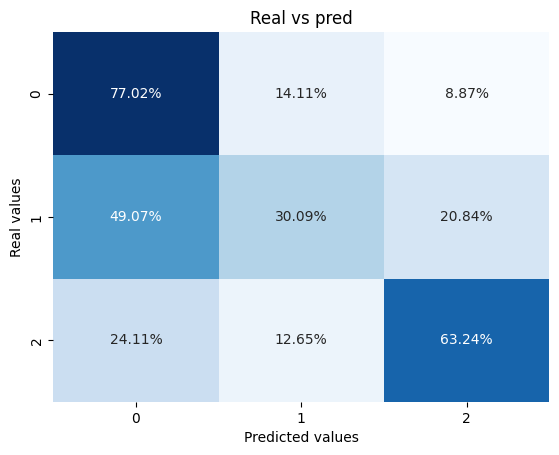

In [128]:
# Evaluamos modelo
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg_cv_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

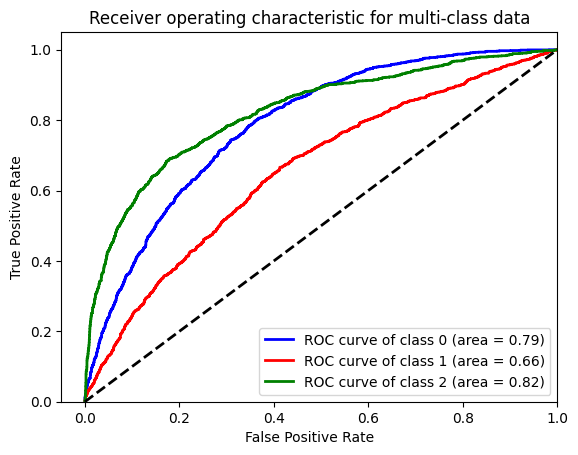

In [129]:
# Compute ROC curve and ROC area for each class
n_classes = 3
y_score = clf_LR_emb.decision_function(X_test_embeddings)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### SVC

In [130]:
pipe_lin_svc_emb = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svc', SVC(kernel='linear',probability=True))
])
pipe_lin_svc_params = dict(svc__C = [0.01, 0.1, 0.25, 0.5, 1, 1.5])

lin_svc_cv_emb = GridSearchCV(pipe_lin_svc_emb,
                          pipe_lin_svc_params,
                          cv = 10,
                          n_jobs = -1,
                          scoring = 'f1')
lin_svc_cv_emb.fit(np.array(X_train_embeddings), y_train)
lin_svc_cv_emb.best_params_
y_pred_lin_svc_cv_emb = lin_svc_cv_emb.predict(X_test_embeddings)


In [131]:
emb_svc_lineal = ['LinearSVC','Embedding',accuracy_score(y_test, y_pred_lin_svc_cv_emb),f1_score(y_test, y_pred_lin_svc_cv_emb,average='macro'),
                  precision_score(y_test, y_pred_lin_svc_cv_emb,average='macro'),balanced_accuracy_score(y_test, y_pred_lin_svc_cv_emb),
                  0]
emb_svc_lineal

['LinearSVC',
 'Embedding',
 0.593154146565587,
 0.5780196948850194,
 0.5832060648954301,
 0.5765225591324468,
 0]

In [132]:
# Sacamos matriz de correlación
print(classification_report(y_test, y_pred_lin_svc_cv_emb))

              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1758
           1       0.44      0.40      0.42      1243
           2       0.69      0.62      0.65      1352

    accuracy                           0.59      4353
   macro avg       0.58      0.58      0.58      4353
weighted avg       0.59      0.59      0.59      4353



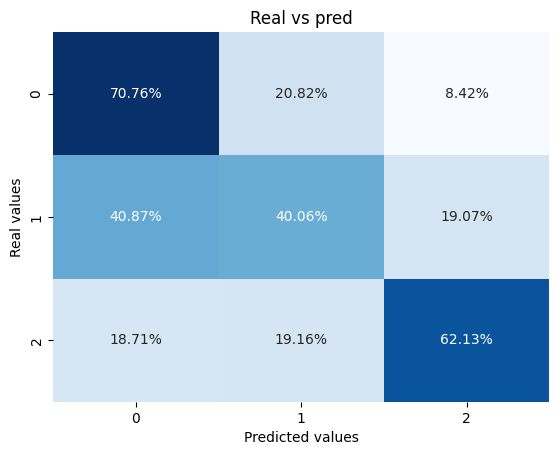

In [133]:
#display_cm(y_test, y_pred_rf_cv)

sns.heatmap(confusion_matrix(y_test,y_pred_lin_svc_cv_emb, normalize = 'true'),
            annot=True,fmt='.2%' ,cmap = 'Blues', cbar = False);

plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

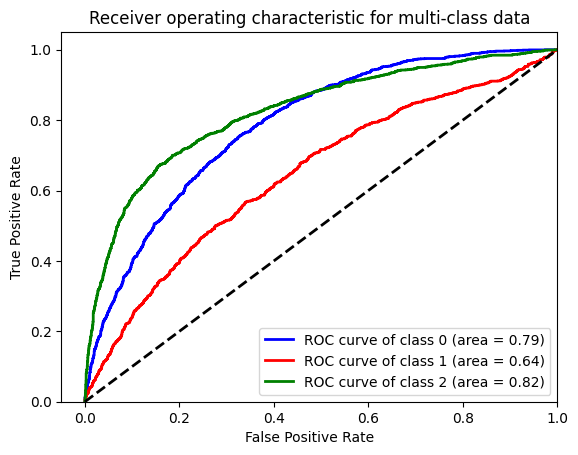

In [134]:
n_classes = 3
y_score = lin_svc_cv_emb.decision_function(X_test_embeddings)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### GaussianNB

In [135]:
clf_GN_emb = GaussianNB()
clf_GN_emb.fit(X_train_embeddings, y_train)
y_pred_clf_GN_emb = clf_GN_emb.predict(X_test_embeddings)

In [136]:
print(classification_report(y_test,y_pred_clf_GN_emb))

              precision    recall  f1-score   support

           0       0.62      0.65      0.64      1758
           1       0.44      0.40      0.42      1243
           2       0.62      0.64      0.63      1352

    accuracy                           0.58      4353
   macro avg       0.56      0.56      0.56      4353
weighted avg       0.57      0.58      0.57      4353



In [137]:
emb_GaussianNB = ['GaussianNB','Embedding',accuracy_score(y_test, y_pred_clf_GN_emb),f1_score(y_test, y_pred_clf_GN_emb,average='macro'),
                  precision_score(y_test, y_pred_clf_GN_emb,average='macro'),balanced_accuracy_score(y_test, y_pred_clf_GN_emb),
                  roc_auc_score(y_test,clf_GN_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_GaussianNB

['GaussianNB',
 'Embedding',
 0.5750057431656329,
 0.5613740622835475,
 0.5612129555804181,
 0.5625877928586697,
 0.7435535147098852]

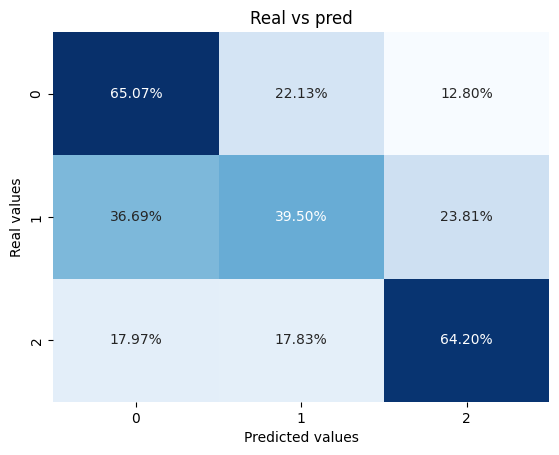

In [138]:
sns.heatmap(confusion_matrix(y_test, y_pred_clf_GN_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

## Métodos de Ensamble

### Random Forest

Barrido de n_estimator = 100 hasta 400 aumentos de 50 
max_depth ---> 2,10 incremtos de 2
min_samples_leaf ----1,2,3
criterion ----> “gini”, “entropy”
class_weight--> “balanced”, “balanced_subsample []

In [139]:
random_forest_cv_emb = RandomForestClassifier(class_weight= 'balanced_subsample',
 criterion= 'entropy',
 max_depth= 10,
 min_samples_leaf= 1,
 n_estimators= 350,random_state= 123)
random_forest_cv_emb.fit(X_train_embeddings, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, n_estimators=350, random_state=123)

In [140]:
y_pred_rf_cv_emb = random_forest_cv_emb.predict(X_test_embeddings)
print(classification_report(y_test, y_pred_rf_cv_emb))

              precision    recall  f1-score   support

           0       0.60      0.74      0.66      1758
           1       0.46      0.32      0.38      1243
           2       0.64      0.62      0.63      1352

    accuracy                           0.58      4353
   macro avg       0.57      0.56      0.56      4353
weighted avg       0.57      0.58      0.57      4353



In [141]:
emb_rf = ['RandomForest','Embedding',accuracy_score(y_test, y_pred_rf_cv_emb ),f1_score(y_test, y_pred_rf_cv_emb ,average='macro'),
                  precision_score(y_test, y_pred_rf_cv_emb ,average='macro'),balanced_accuracy_score(y_test, y_pred_rf_cv_emb ),
                  roc_auc_score(y_test,random_forest_cv_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_rf

['RandomForest',
 'Embedding',
 0.5844245348035837,
 0.5581579340626402,
 0.5679371837900895,
 0.5619818728527841,
 0.7525577337354926]

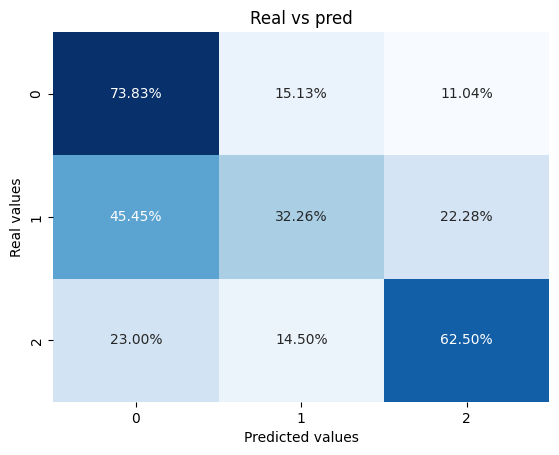

In [142]:
sns.heatmap(confusion_matrix(y_test,y_pred_rf_cv_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
plt.show()

## HistGradientBoostingClassifier

In [143]:
clf_hgb_emb = HistGradientBoostingClassifier()
clf_hgb_emb.fit(X_train_embeddings, y_train)

y_pred_clf_hgb_emb = clf_hgb_emb.predict(X_test_embeddings)


In [144]:
emb_HGB = ['HistGradiantBoosting','Embedding',accuracy_score(y_test, y_pred_clf_hgb_emb),f1_score(y_test, y_pred_clf_hgb_emb,average='macro'),
                  precision_score(y_test, y_pred_clf_hgb_emb,average='macro'),balanced_accuracy_score(y_test, y_pred_clf_hgb_emb),
                  roc_auc_score(y_test,clf_hgb_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_HGB

['HistGradiantBoosting',
 'Embedding',
 0.582127268550425,
 0.5664545432735578,
 0.5711590954652656,
 0.5653477426118841,
 0.749890923611286]

In [145]:
print(classification_report(y_test, y_pred_clf_hgb_emb))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65      1758
           1       0.44      0.39      0.41      1243
           2       0.66      0.60      0.63      1352

    accuracy                           0.58      4353
   macro avg       0.57      0.57      0.57      4353
weighted avg       0.58      0.58      0.58      4353



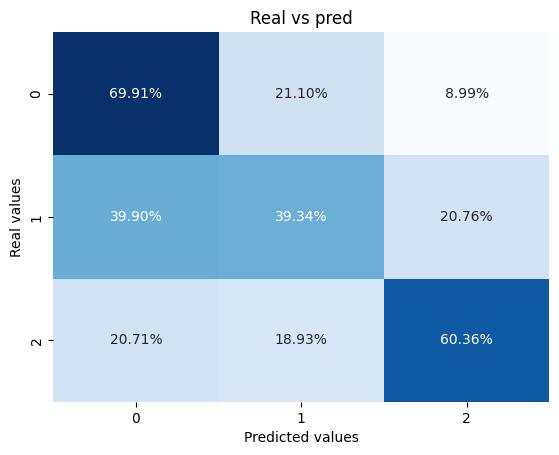

In [146]:
sns.heatmap(confusion_matrix(y_test,y_pred_clf_hgb_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

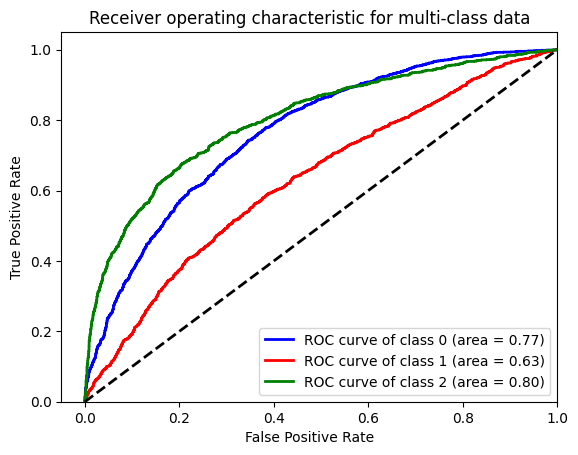

In [147]:
n_classes = 3
y_score = clf_hgb_emb.decision_function(X_test_embeddings)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### Gradiant Boosting Classifer

In [148]:
clf_GBC_emb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train_embeddings, y_train)
y_predict_clf_GBC_emb = clf_GBC_emb.predict(X_test_embeddings)

In [149]:
emb_GBC = ['GradientBoosting','Embedding',accuracy_score(y_test, y_predict_clf_GBC_emb),f1_score(y_test, y_predict_clf_GBC_emb,average='macro'),
                  precision_score(y_test, y_predict_clf_GBC_emb,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_GBC_emb),
                  roc_auc_score(y_test,clf_GBC_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_GBC

['GradientBoosting',
 'Embedding',
 0.5644383184011027,
 0.5511598590579593,
 0.5537568213583873,
 0.5502137480997518,
 0.7385741555228478]

In [150]:
print(classification_report(y_test, y_predict_clf_GBC_emb))

              precision    recall  f1-score   support

           0       0.60      0.66      0.63      1758
           1       0.42      0.39      0.41      1243
           2       0.64      0.60      0.62      1352

    accuracy                           0.56      4353
   macro avg       0.55      0.55      0.55      4353
weighted avg       0.56      0.56      0.56      4353



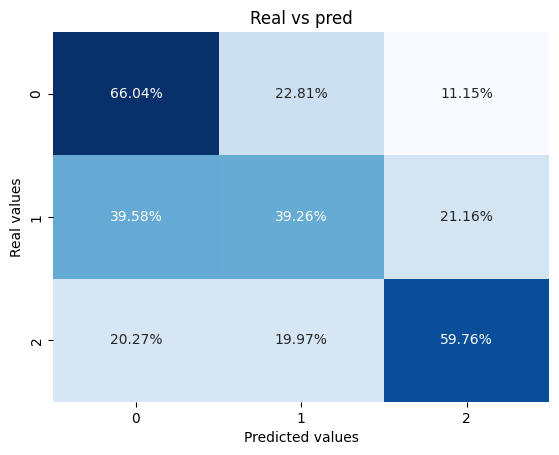

In [151]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_GBC_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

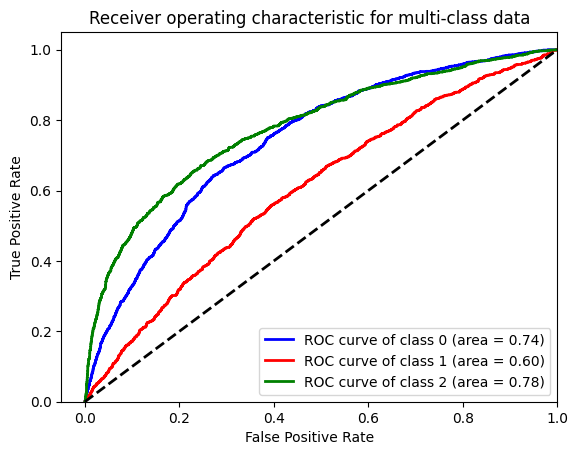

In [152]:
n_classes = 3
y_score = clf_GBC_emb.decision_function(X_test_embeddings)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


### VotingClassifier

In [153]:
eclf2_emb = VotingClassifier(estimators=[
         ('lr', clf_LR_emb ), ('SVC_Lineal',lin_svc_cv_emb) ],
         voting='soft')
eclf2_emb = eclf2_emb.fit(X_train_embeddings.numpy(), y_train)
y_predict_clf_VT_emb= eclf2_emb.predict(X_test_embeddings.numpy())

In [154]:
emb_VT = ['VotingClassfier','Embedding',accuracy_score(y_test, y_predict_clf_VT_emb),f1_score(y_test, y_predict_clf_VT_emb,average='macro'),
                  precision_score(y_test, y_predict_clf_VT_emb,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_VT_emb),
                  roc_auc_score(y_test,eclf2_emb.predict_proba(X_test_embeddings.numpy()),multi_class='ovr')]
emb_VT

['VotingClassfier',
 'Embedding',
 0.600275671950379,
 0.5770708503454438,
 0.5853966722373851,
 0.5788747063234944,
 0.7624315595545162]

In [155]:
print(classification_report(y_test, y_predict_clf_VT_emb))

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      1758
           1       0.46      0.35      0.40      1243
           2       0.68      0.64      0.66      1352

    accuracy                           0.60      4353
   macro avg       0.59      0.58      0.58      4353
weighted avg       0.59      0.60      0.59      4353



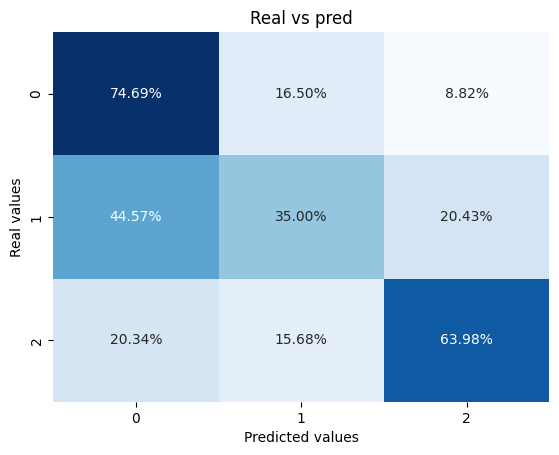

In [156]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_VT_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

### StackingClassifier

In [157]:
estimators = [('lr', LogisticRegression(C = 1.5 , class_weight = None, penalty = 'l2', solver ='newton-cg', random_state=0)),
('rf', RandomForestClassifier(class_weight= 'balanced_subsample',criterion= 'entropy', max_depth= 10, min_samples_leaf= 1, n_estimators= 350,random_state= 123)),
('GB',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0))]
clf_SC_emb = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())

In [158]:
clf_SC_emb.fit(X_train_embeddings.numpy(), y_train)
y_predict_clf_SC_emb= clf_SC_emb.predict(X_test_embeddings.numpy())

In [159]:
emb_StC = ['StackingClassifer','Embedding',accuracy_score(y_test, y_predict_clf_SC_emb),f1_score(y_test, y_predict_clf_SC_emb,average='macro'),
                  precision_score(y_test, y_predict_clf_SC_emb,average='macro'),balanced_accuracy_score(y_test, y_predict_clf_SC_emb),
                  roc_auc_score(y_test,clf_SC_emb.predict_proba(X_test_embeddings.numpy()),multi_class='ovr')]
emb_StC

['StackingClassifer',
 'Embedding',
 0.5683436710314725,
 0.5487638877188298,
 0.5558344340586913,
 0.5483624580047352,
 0.7407104984295833]

In [160]:
print(classification_report(y_test, y_predict_clf_SC_emb))

              precision    recall  f1-score   support

           0       0.59      0.71      0.65      1758
           1       0.41      0.35      0.38      1243
           2       0.66      0.59      0.62      1352

    accuracy                           0.57      4353
   macro avg       0.56      0.55      0.55      4353
weighted avg       0.56      0.57      0.56      4353



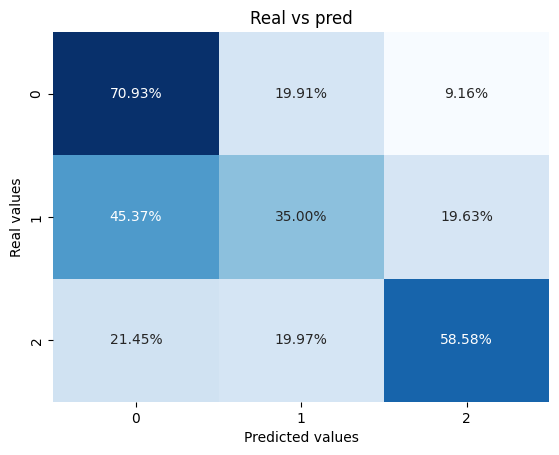

In [161]:
sns.heatmap(confusion_matrix(y_test,y_predict_clf_SC_emb, normalize = 'true'),
            annot=True, fmt='.2%', cmap = 'Blues', cbar = False);
plt.title('Real vs pred')
plt.xlabel('Predicted values')
plt.ylabel('Real values');
    
plt.show()

### XGrandient Boosting

In [162]:
xgbr_clf_emb = xgb.XGBClassifier(booster = 'dart', eta = 0.5, gamma = 0.3 , learning_rate= 0.05,seed = 20)
xgbr_clf_emb.fit(X_train_embeddings.numpy(), y_train_xgbr)
y_clf_xgbr_emb = xgbr_clf_emb.predict(X_test_embeddings.numpy())

In [163]:
print(classification_report(y_test_xgbr, y_clf_xgbr_emb))

              precision    recall  f1-score   support

           0       0.59      0.75      0.66      1758
           1       0.45      0.34      0.39      1243
           2       0.66      0.59      0.62      1352

    accuracy                           0.58      4353
   macro avg       0.57      0.56      0.56      4353
weighted avg       0.57      0.58      0.57      4353



In [164]:
emb_Xgbrt = ['XGBClassifier','Embeding',accuracy_score(y_test_xgbr, y_clf_xgbr_emb),f1_score(y_test_xgbr, y_clf_xgbr_emb,average='macro'),
          precision_score(y_test_xgbr, y_clf_xgbr_emb,average='macro'),balanced_accuracy_score(y_test_xgbr, y_clf_xgbr_emb),
          roc_auc_score(y_test_xgbr, xgbr_clf_emb.predict_proba(X_test_embeddings),multi_class='ovr')]
emb_Xgbrt

['XGBClassifier',
 'Embeding',
 0.5816678152997933,
 0.5573242440204083,
 0.5692364863613881,
 0.558579990827962,
 0.7506629372040488]

## Resultados

In [165]:
ideal =['Ideal','Ideal',1,1,1,1,1]
todas_las_medidas = [ideal,ct_lr,ct_svc_lineal,ct_GauNB,ct_rf,ct_HBG,ct_GBc,ct_VC,ct_StC,ct_Xgbrt,
                     tfc_lr,tfc_scv_lineal,tfc_GaussianNb,tfc_rf,tfc_HGB,tfc_GBC,tfc_StC,tfc_Xgbrt,
                     emb_lr,emb_svc_lineal,emb_GaussianNB,emb_rf,emb_HGB,emb_GBC,emb_VT, emb_StC,emb_Xgbrt]
df_resultados = pd.DataFrame(todas_las_medidas,columns=['Model','Vectorizacion','Accuracy','F1','Presicion','Balanced Accurracy', 'ROC AUC'])
df_resultados = df_resultados.sort_values(by = 'Accuracy',ascending= False)
df_resultados['Categoria'] = df_resultados['Model']+'_' +df_resultados['Vectorizacion']
df_resultados_ = df_resultados[['Accuracy', 'F1', 'Presicion',
       'Balanced Accurracy', 'ROC AUC', 'Categoria']]
df_resultados_ = df_resultados_.set_index('Categoria') 
df_resultados_stack = df_resultados_.stack()
df_resultados_stack
df_resultados_stack_final = df_resultados_stack.reset_index()

In [166]:
df_resultados

,Model,Vectorizacion,Accuracy,F1,Presicion,Balanced Accurracy,ROC AUC,Categoria
0,Ideal,Ideal,1.000000,1.000000,1.000000,1.000000,1.000000,Ideal_Ideal
8,StackingClassifier,CountVectorizer,0.602343,0.585444,0.589707,0.585187,0.768838,StackingClassifier_CountVectorizer
24,VotingClassfier,Embedding,0.600276,0.577071,0.585397,0.578875,0.762432,VotingClassfier_Embedding
1,regresion_logistica,CountVectorizer,0.597519,0.585393,0.588213,0.584171,0.763052,regresion_logistica_CountVectorizer
7,VotingClassifier,CountVectorizer,0.596600,0.580865,0.586821,0.579742,0.765002,VotingClassifier_CountVectorizer
16,StackingClassifer,TfidfVectorizer,0.593614,0.574391,0.579184,0.575324,0.768299,StackingClassifer_TfidfVectorizer
18,LogisticRegresion,Embedding,0.593384,0.562844,0.578707,0.567825,0.761155,LogisticRegresion_Embedding
19,LinearSVC,Embedding,0.593154,0.578020,0.583206,0.576523,0.000000,LinearSVC_Embedding
10,LogisticRegression,TfidfVectorizer,0.586952,0.555964,0.578635,0.559857,0.762919,LogisticRegression_TfidfVectorizer
21,RandomForest,Embedding,0.584425,0.558158,0.567937,0.561982,0.752558,RandomForest_Embedding


In [167]:
polar_fig = px.line_polar(df_resultados_stack_final, r=0, theta='level_1',color='Categoria',range_r=[0,1.2],width=1200, height=1200)
polar_fig.show()

# Redes Neuronales


In [168]:
df_initial['Dataset'] = 'Train'
df_final['Dataset'] = 'Test'
df = pd.concat([df_initial,df_final])

In [169]:
from tensorflow import keras


# Número de palabras del modelo
tokens = set()
for tweet in df.tweet_:
    for word in tweet.split():
        tokens.add(word)
dim = len(tokens)        
print('Número total de palabras:', dim)
        

Número total de palabras: 13654


In [170]:
INPUT_LENGTH = 25
EMBED_DIM = 128
MAX_LEN = 250

# Creamos tokenizador
tokenizer = keras.preprocessing.text.Tokenizer(num_words = dim)
tokenizer.fit_on_texts(df_initial.tweet_)
sequences = tokenizer.texts_to_sequences(df_initial.tweet_)
X = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen = INPUT_LENGTH

)
y_ = pd.get_dummies(df_initial.classification).values


In [171]:
len(X[0])

25

In [172]:
# Separamos train/test
from sklearn.model_selection import train_test_split
x_train_, x_test_, y_train_, y_test_ = train_test_split(X, y_,
                                                    random_state = 42,
                                                    test_size = 0.3)

In [173]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

# Definimos parámetros para el modelo
DROPOUT_VAL = 0.3
BATCH_SIZE = 16
EPOCHS = 5

# Creamos capas

layers = [
    keras.layers.Embedding(dim, 20, input_length = INPUT_LENGTH),
    keras.layers.Conv1D(64,5),
    keras.layers.Conv1D(32,3),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(140,dropout = DROPOUT_VAL, return_sequences=True),
    keras.layers.LSTM(140,dropout = DROPOUT_VAL),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(3, activation = 'softmax')   
]

model = keras.models.Sequential(layers)

# Compilamos

model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
                            

In [174]:
# Entrenamos

history_2 = model.fit(x_train_,
                       y_train_,
                       epochs = EPOCHS,
                       validation_data = (x_test_, y_test_),
                       batch_size = 16)

Epoch 1/5
317/317 [==============================] - 9s 18ms/step - loss: 1.0294 - accuracy: 0.4716 - val_loss: 1.0267 - val_accuracy: 0.4556
Epoch 2/5
317/317 [==============================] - 5s 17ms/step - loss: 0.7850 - accuracy: 0.6475 - val_loss: 0.9565 - val_accuracy: 0.5518
Epoch 3/5
317/317 [==============================] - 5s 17ms/step - loss: 0.4821 - accuracy: 0.8107 - val_loss: 1.2432 - val_accuracy: 0.5071
Epoch 4/5
317/317 [==============================] - 5s 17ms/step - loss: 0.2658 - accuracy: 0.9085 - val_loss: 1.5444 - val_accuracy: 0.5122
Epoch 5/5
317/317 [==============================] - 5s 17ms/step - loss: 0.1590 - accuracy: 0.9481 - val_loss: 1.7920 - val_accuracy: 0.5145


In [175]:
# Evaluamos
accuracy_dl_lstm = model.evaluate(x_test_, y_test_)
accuracy_dl_lstm

68/68 [==============================] - 0s 6ms/step - loss: 1.7920 - accuracy: 0.5145


[1.7920454740524292, 0.5144960880279541]

In [176]:

# Sacamos classification report
y_pred_2 = model.predict(x_test_)
print(classification_report(np.argmax(y_test_, axis=1), np.argmax(y_pred_2, axis=1)))

68/68 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.57      0.62      0.59       867
           1       0.43      0.36      0.39       699
           2       0.51      0.55      0.53       607

    accuracy                           0.51      2173
   macro avg       0.50      0.51      0.50      2173
weighted avg       0.51      0.51      0.51      2173



# Pysentimiento 

In [ ]:
X_train_pysen, y_train = df_initial['tweet_2'], df_initial['classification']
X_test_pysen, y_test = df_final['tweet_2'], df_final['classification']
y_test_binarize = label_binarize(y_test,classes=[0,1,2])
# Vectorizamos
from sklearn.feature_extraction.text import CountVectorizer

# Creamos objeto y entrenamos
df_vectorizer_2 = CountVectorizer(binary = True,
                                      ngram_range=(1, 3))
df_vectorizer_2.fit(X_train_pysen)

# Transformamos X en sparse vector
X_train_pysen_vec = df_vectorizer_2.transform(X_train_pysen)
X_test_pysen_vec = df_vectorizer_2.transform(X_test_pysen)

In [ ]:
# Creamos modelo
lr_cv_params = dict(C = np.arange(0.25,2.25,0.25),
                    class_weight = [None, 'balanced'],
                    solver = ['newton-cg', 'sag', 'lbfgs'])

lr_cv_grid = GridSearchCV(LogisticRegression(max_iter = 300),
                     lr_cv_params,
                     cv = 5,
                     n_jobs = -1,
                     scoring = 'f1').fit(X_train_pysen_vec,
                                               y_train)
print('Best score:', lr_cv_grid.best_score_)
print('Best params:', lr_cv_grid.best_params_)

In [ ]:
clf_LR_pysen = LogisticRegression(C =0.50,solver= 'newton-cg', random_state=1234).fit(X_train_pysen_vec, y_train)
y_pred_log_reg_cv_2 = clf_LR_pysen.predict(X_test_pysen_vec)

In [ ]:
print(classification_report(y_test,y_pred_log_reg_cv_2))

In [ ]:
X_train_embeddings_py = embed(X_train_pysen)
X_test_embeddings_py = embed(X_test_pysen)

In [ ]:
clf_LR_pysen = LogisticRegression( random_state=0).fit(X_train_embeddings, y_train)
y_pred_log_reg_cv_2 = clf_LR_pysen.predict(X_test_embeddings_py)

In [ ]:
print(classification_report(y_test,y_pred_log_reg_cv_2))

# Berta

In [177]:
import torch
import torch.utils.data as data_utils

from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [178]:
run_on = 'cpu'
device = torch.device(run_on)

In [181]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenizar los textos de entrenamiento
train_tokens = tokenizer.batch_encode_plus(
    df_initial.tweet_.values,
    padding=True,
    truncation=True,
    max_length=128
)

# Tokenizar los textos de prueba
test_tokens = tokenizer.batch_encode_plus(
    df_final.tweet_.values,
    padding=True,
    truncation=True,
    max_length=128
)

# Convertir los datos a tensores de PyTorch
train_inputs = torch.tensor(train_tokens['input_ids'])
train_masks = torch.tensor(train_tokens['attention_mask'])
train_labels = torch.tensor(df_initial.classification.values)

test_inputs = torch.tensor(test_tokens['input_ids'])
test_masks = torch.tensor(test_tokens['attention_mask'])
test_labels = torch.tensor(df_final.classification.values)

# Crear conjuntos de datos de PyTorch
train_dataset = data_utils.TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = data_utils.TensorDataset(test_inputs, test_masks, test_labels)


In [182]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
            num_warmup_steps = 0, 
            num_training_steps = len(df_initial) * 5)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [188]:
def train_model(model, optimizer, scheduler, train_loader, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['train_inputs'].to(device)
        attention_mask = batch['train_masks'].to(device)
        labels = batch['train_labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return total_loss / len(train_loader)

In [184]:
def evaluate_model(model, test_loader, device):
    model.eval()
    true_labels = []
    predicted_labels = []
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predictions.tolist())
    return true_labels, predicted_labels

In [189]:
train_model(model, optimizer, scheduler, train_dataset, device)

TypeError: tuple indices must be integers or slices, not str

In [ ]:
true_labels, predicted_labels = evaluate_model(model, test_loader, device)
print(predicted_labels)